# Part 1: Baseline (Telco Churn)

**Goal of this baseline:**  
Build a **solid and reproducible** base model with:
- Minimal EDA (distributions, correlations, and short conclusions)
- Preprocessing with `Pipeline`/`ColumnTransformer` and **custom transformers**
- Base model: **Logistic Regression**
- Metrics on **validation** and **test**: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC
- **Threshold tuning** (F1) on validation, applied later to test
- **Summary table** for later comparison with ensemble models (Bagging, Boosting, Stacking, Voting)


In [ ]:
# !pip install pandas numpy matplotlib seaborn scipy
# !pip install sklearn

# !python -m pip --version
# !python -c "import sys,site; print(sys.executable); print(site.getsitepackages())"
# !python -m pip uninstall -y sklearn scikit-learn
# !python -m pip install --force-reinstall --no-deps matplotlib==3.10.0
# !python -m pip install -U matplotlib
# !python -m pip install -U pip setuptools wheel
# !python -m pip install -U scikit-learn
# !python -m pip check 



In [70]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import RobustScaler 
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 


### Variable description

The **Telco Customer Churn** dataset contains information on **7043 customers** from a telecommunications company.  
Each row represents a customer and the target (`Churn`) indicates whether they **left the service** (`Yes`) or **are still active** (`No`).

**Variables:**

- **customerID:** Unique customer identifier. Not useful for the model and removed.  
- **gender:** Customer gender (`Male`, `Female`).  
- **SeniorCitizen:** Whether the customer is a senior citizen (`1 = Yes`, `0 = No`).  
- **Partner:** Whether the customer has a partner (`Yes`, `No`).  
- **Dependents:** Whether the customer has dependents (children or others) (`Yes`, `No`).  
- **tenure:** Time as a customer, in **months** (0–72).  
- **PhoneService:** Whether they have phone service (`Yes`, `No`).  
- **MultipleLines:** Whether they have multiple lines (`Yes`, `No`, or `No phone service`).  
- **InternetService:** Type of internet service (`DSL`, `Fiber optic`, `No`).  
- **OnlineSecurity:** Online security service (`Yes`, `No`, or `No internet service`).  
- **OnlineBackup:** Online backup service (`Yes`, `No`, or `No internet service`).  
- **DeviceProtection:** Device protection (`Yes`, `No`, or `No internet service`).  
- **TechSupport:** Technical support (`Yes`, `No`, or `No internet service`).  
- **StreamingTV:** TV streaming (`Yes`, `No`, or `No internet service`).  
- **StreamingMovies:** Movie streaming (`Yes`, `No`, or `No internet service`).  
- **Contract:** Contract type (`Month-to-month`, `One year`, `Two year`).  
- **PaperlessBilling:** Whether billing is paperless (`Yes`, `No`).  
- **PaymentMethod:** Payment method (`Electronic check`, `Mailed check`, `Bank transfer (automatic)`, `Credit card (automatic)`).  
- **MonthlyCharges:** Current monthly charge (**USD/month**).  
- **TotalCharges:** Total amount charged since start (**accumulated USD**).  
- **Churn:** Target variable (`Yes` = customer left, `No` = still active).  

**Notes:**
- The variable `TotalCharges` comes as text and is converted to numeric. **11 missing values** are detected and imputed with the **median**.  
- The values `"No internet service"` and `"No phone service"` are replaced with `"No"` during preprocessing.  
- Categorical variables are encoded using **OneHotEncoder**, and numeric variables are scaled using **RobustScaler**.  
- Additionally, a new feature `tenure_x_monthly` is created (interaction between tenure and monthly charge).  


In [71]:
DATA_PATH = r"D:\Archivos de Usuario/Documents/Machine_Learning/Machine-Learning/Mid_Machine/WA_Fn-UseC_-Telco-Customer-Churn.csv" # Ajustar al path que tengan para que funcione

telco_df = pd.read_csv(DATA_PATH)
telco_df.head(10)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [72]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [73]:
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


### 1) EDA
Class distribution, numeric distributions, boxplots, class-wise densities by `Churn`, and correlations (Pearson).


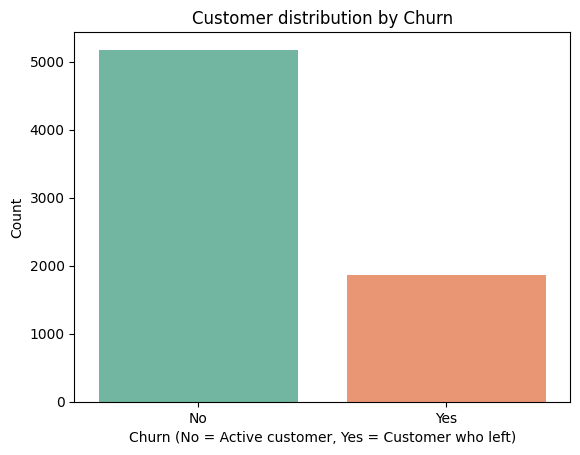

In [83]:
# Global class distribution
sns.countplot(x="Churn", data=telco_df, hue="Churn", palette="Set2", legend=False)
plt.title("Customer distribution by Churn")
plt.xlabel("Churn (No = Active customer, Yes = Customer who left)")
plt.ylabel("Count")
plt.show()


In [84]:
# Class proportion (Yes)
p_yes = (telco_df["Churn"].astype(str).str.strip() == "Yes").mean()
print(f"Proportion of Churn=Yes: {p_yes:.3f}")


Proportion of Churn=Yes: 0.265


In [85]:
# Missing values in numeric columns after converting TotalCharges
_chk = telco_df.copy()
_chk["TotalCharges"] = pd.to_numeric(_chk["TotalCharges"], errors="coerce")
print(_chk[["tenure","MonthlyCharges","TotalCharges"]].isna().sum())

tenure             0
MonthlyCharges     0
TotalCharges      11
dtype: int64


#### Distributions of key numeric variables


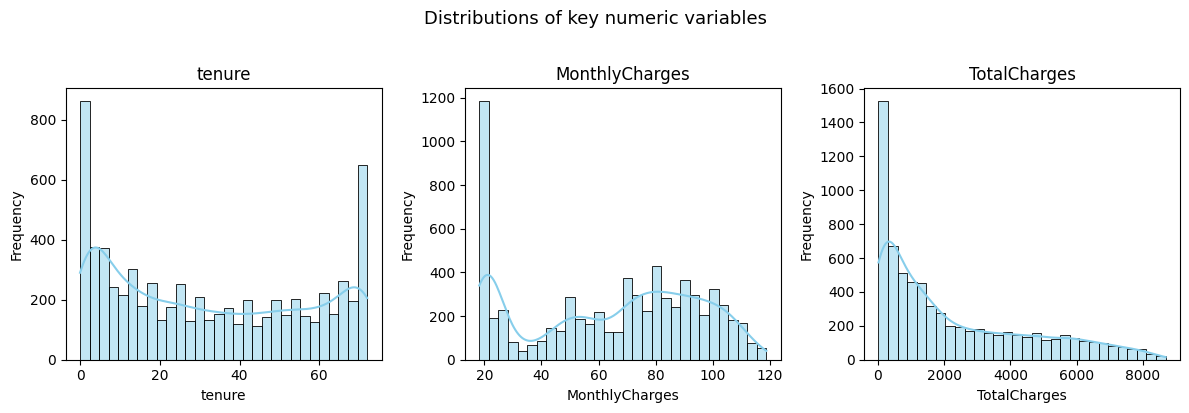

In [87]:
# Ensure TotalCharges is numeric
telco_num = telco_df.copy()
telco_num["TotalCharges"] = pd.to_numeric(telco_num["TotalCharges"], errors="coerce")

num_cols_quick = ["tenure", "MonthlyCharges", "TotalCharges"]

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols_quick, 1):
    plt.subplot(1, 3, i)
    sns.histplot(telco_num[col], bins=30, kde=True, color="skyblue", edgecolor="black")
    plt.title(f"{col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.suptitle("Distributions of key numeric variables", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

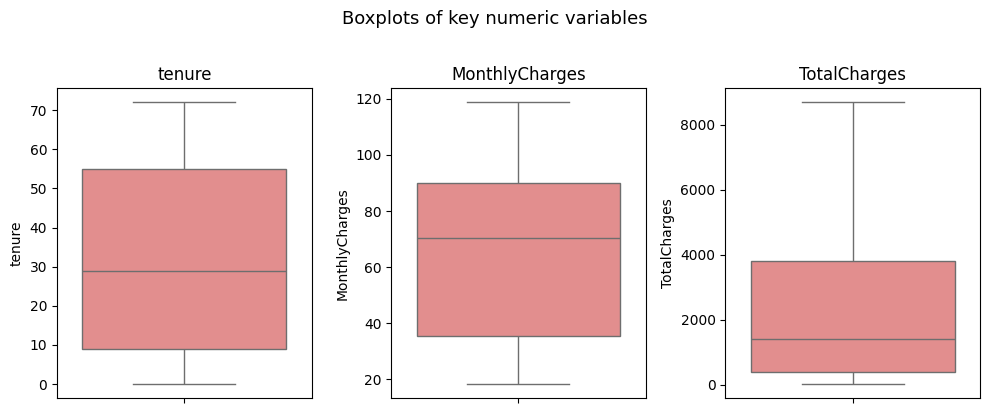

In [89]:
# Boxplots
plt.figure(figsize=(10, 4))
for i, col in enumerate(num_cols_quick, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=telco_num, y=col, color="lightcoral", fliersize=2)
    plt.title(f"{col}")
plt.suptitle("Boxplots of key numeric variables", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

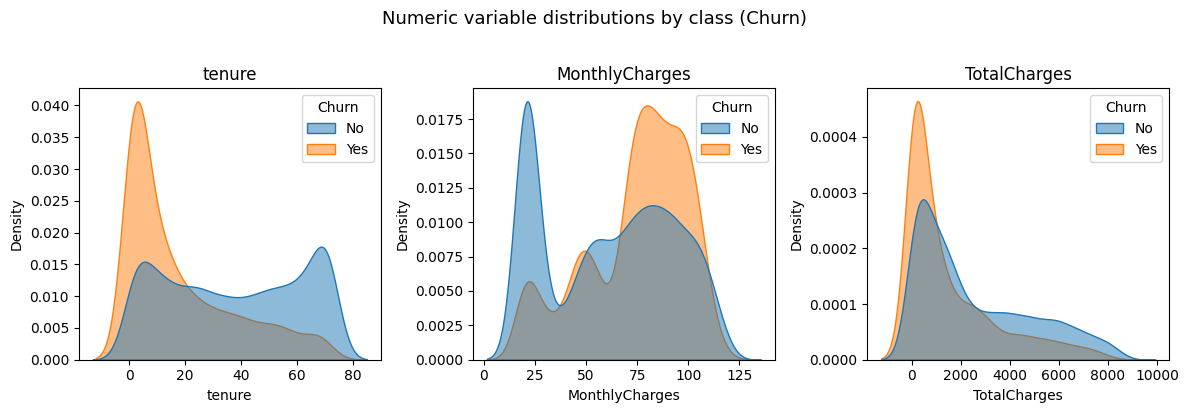

In [91]:
# Distributions by class (Churn)
plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols_quick, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(
        data=telco_num, x=col, hue="Churn", fill=True, common_norm=False, alpha=0.5
    )
    plt.title(f"{col}")
plt.suptitle("Numeric variable distributions by class (Churn)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

#### Numeric correlations


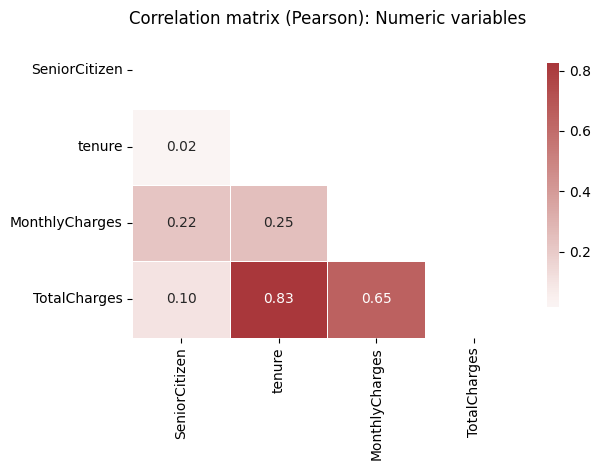

In [94]:
# Numeric correlations with Pearson
num_df = telco_df.copy()
num_df["TotalCharges"] = pd.to_numeric(num_df.get("TotalCharges", pd.Series(dtype=float)), errors="coerce")

num_only = num_df.select_dtypes(include=[np.number])

# Correlation matrix (Pearson)
corr_pearson = num_only.corr(method="pearson")

mask = np.triu(np.ones_like(corr_pearson, dtype=bool))

plt.figure(figsize=(6.4, 4.8))
sns.heatmap(
    corr_pearson,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)
plt.title("Correlation matrix (Pearson): Numeric variables")
plt.tight_layout()
plt.show()


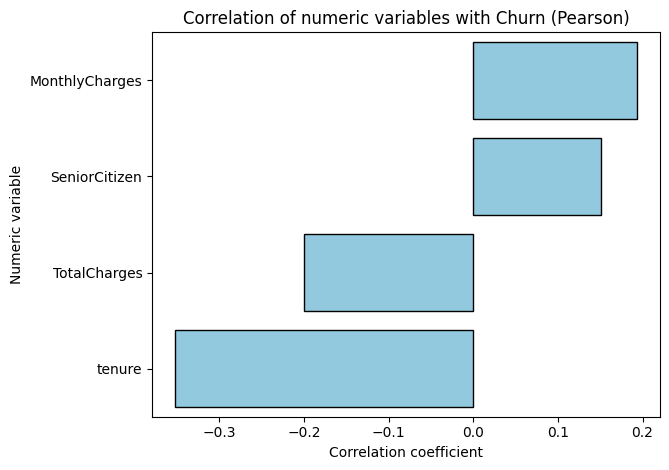

In [95]:
# Correlation of numeric variables with the target (Churn)
# Convert Churn to binary (Yes=1, No=0)
y_bin = (telco_df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

# Direct correlations
corr_with_target = num_only.corrwith(y_bin).sort_values(ascending=False)

plt.figure(figsize=(6.8, 4.8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, color="skyblue", edgecolor="black")
plt.title("Correlation of numeric variables with Churn (Pearson)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Numeric variable")
plt.tight_layout()
plt.show()


### Scatter plots


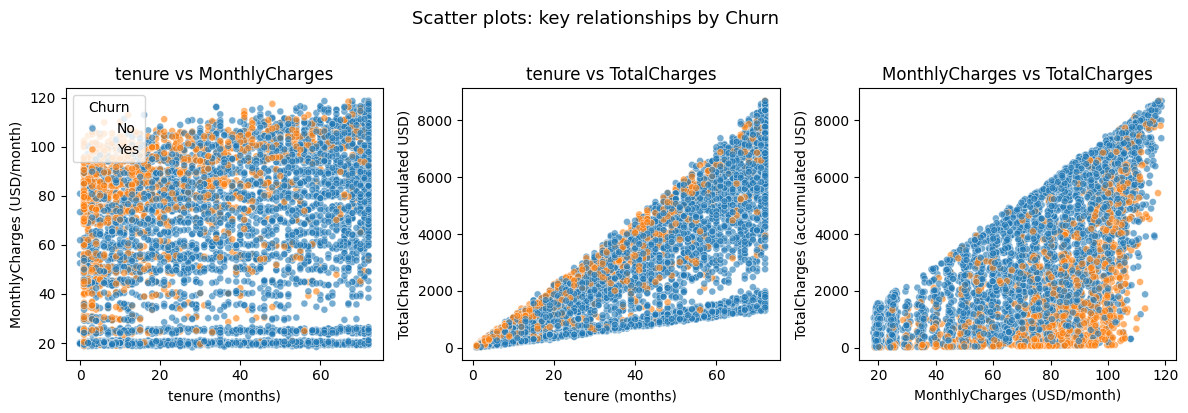

In [97]:
_sc = telco_df.copy()
_sc["TotalCharges"] = pd.to_numeric(_sc["TotalCharges"], errors="coerce")

plt.figure(figsize=(12, 4))
# 1) tenure vs MonthlyCharges
plt.subplot(1, 3, 1)
sns.scatterplot(
    data=_sc, x="tenure", y="MonthlyCharges", hue="Churn", alpha=0.6, s=25
)
plt.title("tenure vs MonthlyCharges")
plt.xlabel("tenure (months)")
plt.ylabel("MonthlyCharges (USD/month)")

# 2) tenure vs TotalCharges (accumulated relation)
plt.subplot(1, 3, 2)
sns.scatterplot(
    data=_sc, x="tenure", y="TotalCharges", hue="Churn", alpha=0.6, s=25, legend=False
)
plt.title("tenure vs TotalCharges")
plt.xlabel("tenure (months)")
plt.ylabel("TotalCharges (accumulated USD)")

# 3) MonthlyCharges vs TotalCharges
plt.subplot(1, 3, 3)
sns.scatterplot(
    data=_sc, x="MonthlyCharges", y="TotalCharges", hue="Churn", alpha=0.6, s=25, legend=False
)
plt.title("MonthlyCharges vs TotalCharges")
plt.xlabel("MonthlyCharges (USD/month)")
plt.ylabel("TotalCharges (accumulated USD)")

plt.suptitle("Scatter plots: key relationships by Churn", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


### Utilities and transformers


In [98]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return train_set, val_set, test_set

In [99]:
def find_best_threshold_by_f1(y_true, y_proba_yes, pos_label='Yes', n_steps=201):
    best_thr, best_f1 = 0.5, -1.0
    best_p, best_r = None, None
    thresholds = np.linspace(0.0, 1.0, n_steps)
    for thr in thresholds:
        y_hat = np.where(y_proba_yes >= thr, pos_label, 'No')
        f1 = f1_score(y_true, y_hat, pos_label=pos_label)
        if f1 > best_f1:
            best_f1 = f1; best_thr = thr
            best_p = precision_score(y_true, y_hat, pos_label=pos_label)
            best_r = recall_score(y_true, y_hat, pos_label=pos_label)
    return best_thr, best_f1, best_p, best_r


def find_threshold_by_recall(y_true, y_proba_yes, target_recall=0.75, pos_label='Yes', n_steps=201):
    best_thr = 0.5; best_f1 = -1.0
    thresholds = np.linspace(0.0, 1.0, n_steps)
    for thr in thresholds:
        y_hat = np.where(y_proba_yes >= thr, pos_label, 'No')
        r = recall_score(y_true, y_hat, pos_label=pos_label)
        if r >= target_recall:
            f1 = f1_score(y_true, y_hat, pos_label=pos_label)
            if f1 > best_f1:
                best_f1 = f1; best_thr = thr
    return best_thr, best_f1

In [100]:
class CategoricalServiceCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._cols = None

    def fit(self, X, y=None):
        self._cols = list(X.columns)
        return self

    def transform(self, X, y=None):
        Xc = X.copy()
        for c in self._cols:
            Xc[c] = (
                Xc[c].astype(str)
                    .str.strip()
                    .replace({'No internet service': 'No', 'No phone service': 'No'})
            )
        return Xc

In [101]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(
            sparse_output=False,
            handle_unknown="ignore",
            drop="if_binary"
        )
        self._cat_cols = None
        self._columns_out = None

    def fit(self, X, y=None):
        Xc = X.astype(str)
        self._cat_cols = list(Xc.columns)
        self._oh.fit(Xc)
        self._columns_out = list(self._oh.get_feature_names_out(self._cat_cols))
        return self

    def transform(self, X, y=None):
        Xc = X.astype(str)
        return self._oh.transform(Xc)

    def get_feature_names_out(self, input_features=None):
        cols = input_features if input_features is not None else self._cat_cols
        return self._oh.get_feature_names_out(cols)

In [102]:
class NumericFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, add_interaction=True, drop_totalcharges=True):
        self.add_interaction = add_interaction
        self.drop_totalcharges = drop_totalcharges
        self._cols = None

    def fit(self, X, y=None):
        self._cols = list(X.columns)
        return self

    def transform(self, X, y=None):
        Xn = X.copy()
        if 'TotalCharges' in Xn.columns:
            Xn['TotalCharges'] = pd.to_numeric(Xn['TotalCharges'], errors='coerce')

        if self.add_interaction and {'tenure', 'MonthlyCharges'}.issubset(Xn.columns):
            Xn['tenure_x_monthly'] = Xn['tenure'] * Xn['MonthlyCharges']

        if self.drop_totalcharges and 'TotalCharges' in Xn.columns:
            Xn = Xn.drop(columns=['TotalCharges'])

        return Xn

In [103]:
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self, add_interaction=True, drop_totalcharges=True, drop_cols=None):
        self.add_interaction = add_interaction
        self.drop_totalcharges = drop_totalcharges
        self.drop_cols = drop_cols if drop_cols is not None else ['customerID']
        self._ct = None
        self._num_cols = None
        self._cat_cols = None
        self._columns_out = None

    def fit(self, X, y=None):
        Xw = X.drop(columns=[c for c in self.drop_cols if c in X.columns], errors='ignore')

        num_cols = list(Xw.select_dtypes(include=['int64', 'float64']).columns)
        if 'TotalCharges' in Xw.columns and 'TotalCharges' not in num_cols:
            num_cols.append('TotalCharges')
        self._num_cols = num_cols

        # categoricals
        self._cat_cols = [c for c in Xw.columns if c not in self._num_cols]

        # pipelines
        num_pipeline = Pipeline([
            ('feats', NumericFeaturizer(add_interaction=self.add_interaction,
                                        drop_totalcharges=self.drop_totalcharges)),
            ('imputer', SimpleImputer(strategy="median")),
            ('rbst_scaler', RobustScaler())
        ])

        cat_pipeline = Pipeline([
            ('clean', CategoricalServiceCleaner()),
            ('oh_df', CustomOneHotEncoder())
        ])

        # ColumnTransformer
        self._ct = ColumnTransformer([
            ("num", num_pipeline, self._num_cols),
            ("cat", cat_pipeline, self._cat_cols),
        ], remainder='drop')

        self._ct.fit(Xw)

        num_out = list(self._num_cols)
        if self.add_interaction and {'tenure','MonthlyCharges'}.issubset(self._num_cols):
            num_out.append('tenure_x_monthly')
        if self.drop_totalcharges and 'TotalCharges' in num_out:
            num_out.remove('TotalCharges')

        oh = self._ct.named_transformers_['cat'].named_steps['oh_df']
        cat_out = list(oh.get_feature_names_out(self._cat_cols))

        self._columns_out = num_out + cat_out
        return self

    def transform(self, X, y=None):
        Xw = X.drop(columns=[c for c in self.drop_cols if c in X.columns], errors='ignore')
        Xt = self._ct.transform(Xw)
        return pd.DataFrame(Xt, columns=self._columns_out, index=X.index)

In [104]:
df = pd.read_csv(DATA_PATH)
df.shape

(7043, 21)

In [105]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### Stratified split and preprocessing


In [106]:
train_set, val_set, test_set = train_val_test_split(df, stratify='Churn', rstate=42)
print("\nLength of the Training Set:", len(train_set))
print("Length of the Validation Set:", len(val_set))
print("Length of Test Set:", len(test_set))


Length of the Training Set: 4225
Length of the Validation Set: 1409
Length of Test Set: 1409


In [107]:
# For each subset, separate labels from features
X_df  = df.drop("Churn", axis=1)
y_df  = df["Churn"].copy()

X_train = train_set.drop("Churn", axis=1); y_train = train_set["Churn"].copy()
X_val   = val_set.drop("Churn", axis=1);   y_val   = val_set["Churn"].copy()
X_test  = test_set.drop("Churn", axis=1);  y_test  = test_set["Churn"].copy()


In [108]:
data_preparer = DataFramePreparer(
    add_interaction=True,
    drop_totalcharges=False,
    drop_cols=['customerID']
)

In [109]:
data_preparer.fit(X_train)

DataFramePreparer(drop_cols=['customerID'], drop_totalcharges=False)

In [110]:
# Transform train / val / test
X_train_prep = data_preparer.transform(X_train)
X_val_prep   = data_preparer.transform(X_val)
X_test_prep  = data_preparer.transform(X_test)

print("\nColumns:", list(X_train_prep.columns)[:10])
print("Shapes -> Train:", X_train_prep.shape, " Val:", X_val_prep.shape, " Test:", X_test_prep.shape)


Columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'tenure_x_monthly', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes']
Shapes -> Train: (4225, 27)  Val: (1409, 27)  Test: (1409, 27)


### Baseline: Logistic Regression (validation)
We report **Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC** and curves; then we tune the **threshold** by F1.


In [51]:
clf = LogisticRegression(max_iter=5000, random_state=42)

In [52]:
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=5000, random_state=42)


Confusion matrix (validation):
 [[941  94]
 [153 221]]


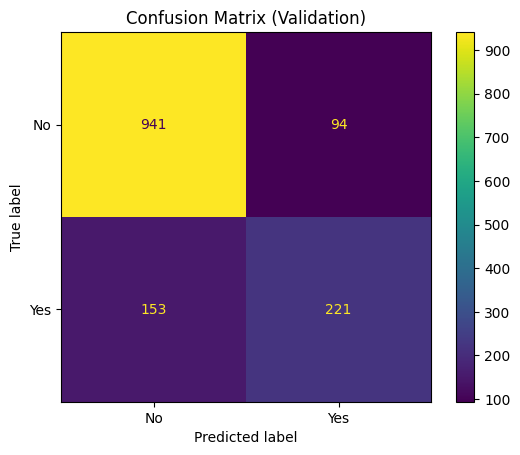

In [113]:
# Prediction on validation (threshold 0.5)
y_pred_val = clf.predict(X_val_prep)
cm_val = confusion_matrix(y_val, y_pred_val)
print("\nConfusion matrix (validation):\n", cm_val)

labels = ['No', 'Yes']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix (Validation)")
plt.show()

In [114]:
# Validation metrics @0.5
acc_val  = accuracy_score(y_val, y_pred_val)
prec_val = precision_score(y_val, y_pred_val, pos_label='Yes')
rec_val  = recall_score(y_val, y_pred_val, pos_label='Yes')
f1_val   = f1_score(y_val, y_pred_val, pos_label='Yes')
print("Accuracy (val):", acc_val)
print("Precision (val, pos='Yes'):", prec_val)
print("Recall    (val, pos='Yes'):",  rec_val)
print("F1 score  (val, pos='Yes'):",  f1_val)


Accuracy (val): 0.8246983676366217
Precision (val, pos='Yes'): 0.7015873015873015
Recall    (val, pos='Yes'): 0.5909090909090909
F1 score  (val, pos='Yes'): 0.6415094339622641


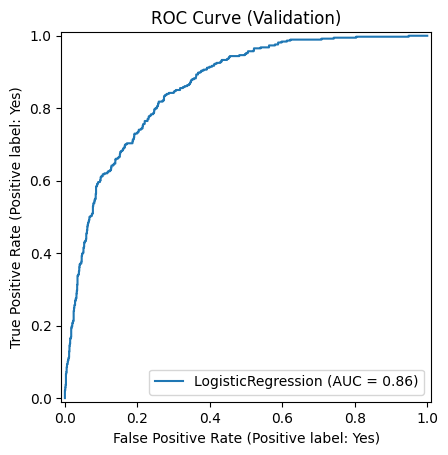

In [ ]:
RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)
plt.title("ROC Curve (Validation)")
plt.show()


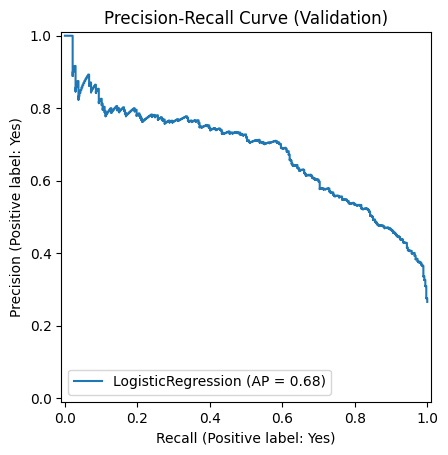

In [116]:
PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val, pos_label='Yes')
plt.title("Precision-Recall Curve (Validation)")
plt.show()

In [117]:
val_proba_yes = clf.predict_proba(X_val_prep)[:, list(clf.classes_).index('Yes')]
roc_auc_val = roc_auc_score(y_val == 'Yes', val_proba_yes)
pr_auc_val  = average_precision_score(y_val == 'Yes', val_proba_yes)
print("ROC-AUC (val):", roc_auc_val)
print("PR-AUC  (val):", pr_auc_val)

ROC-AUC (val): 0.8597974631222713
PR-AUC  (val): 0.6768866466847183


### Threshold tuning by F1 (validation) and final evaluation on test
Fix the threshold on validation and apply it to test **once**.


In [118]:
# Optimal threshold by F1 (validation)
best_thr, best_f1, best_p, best_r = find_best_threshold_by_f1(
    y_val, val_proba_yes, pos_label='Yes', n_steps=201
)
print("\nBest threshold by F1 (val):", best_thr)
print("Val @best_thr -> F1:", best_f1, " Precision:", best_p, " Recall:", best_r)


Best threshold by F1 (val): 0.48
Val @best_thr -> F1: 0.6461538461538462  Precision: 0.6774193548387096  Recall: 0.6176470588235294



Confusion matrix (test, tuned thr):
 [[895 140]
 [170 204]]


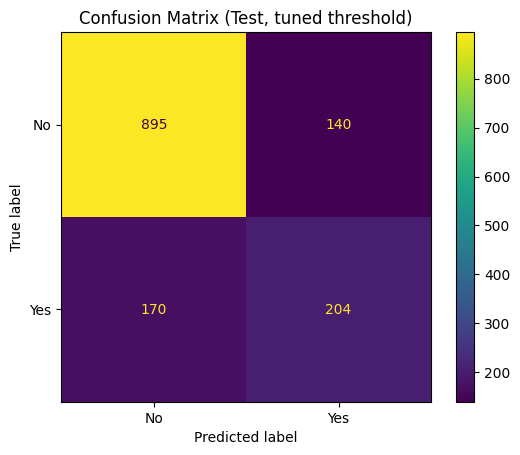

In [119]:
# Test with the optimal threshold
test_proba_yes = clf.predict_proba(X_test_prep)[:, list(clf.classes_).index('Yes')]
y_pred_test_thr = np.where(test_proba_yes >= best_thr, 'Yes', 'No')

cm_test = confusion_matrix(y_test, y_pred_test_thr)
print("\nConfusion matrix (test, tuned thr):\n", cm_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp.plot()
plt.title("Confusion Matrix (Test, tuned threshold)")
plt.show()

In [120]:
# Test metrics @best_thr
acc_test  = accuracy_score(y_test, y_pred_test_thr)
prec_test = precision_score(y_test, y_pred_test_thr, pos_label='Yes')
rec_test  = recall_score(y_test, y_pred_test_thr, pos_label='Yes')
f1_test   = f1_score(y_test, y_pred_test_thr, pos_label='Yes')
roc_auc_test = roc_auc_score(y_test == 'Yes', test_proba_yes)
pr_auc_test  = average_precision_score(y_test == 'Yes', test_proba_yes)

print("Accuracy (test):", acc_test)
print("Precision (test, pos='Yes'):", prec_test)
print("Recall    (test, pos='Yes'):",  rec_test)
print("F1 score  (test, pos='Yes'):",  f1_test)
print("ROC-AUC (test):", roc_auc_test)
print("PR-AUC  (test):", pr_auc_test)


Accuracy (test): 0.7799858055358411
Precision (test, pos='Yes'): 0.5930232558139535
Recall    (test, pos='Yes'): 0.5454545454545454
F1 score  (test, pos='Yes'): 0.5682451253481894
ROC-AUC (test): 0.8320287271693921
PR-AUC  (test): 0.622145410744846


### Summary table (Baseline)
Ready for comparison with Bagging, Boosting, Stacking, and Voting.


In [121]:
summary_baseline = pd.DataFrame({
    "split": ["val", "test"],
    "Accuracy": [acc_val, acc_test],
    "F1_PosYes": [f1_val, f1_test],
    "Precision_PosYes": [prec_val, prec_test],
    "Recall_PosYes": [rec_val, rec_test],
    "ROC_AUC": [roc_auc_val, roc_auc_test],
    "PR_AUC": [pr_auc_val, pr_auc_test],
    "Threshold_Used": [0.5, best_thr]
})
print("\nBaseline summary:")
print(summary_baseline.to_string(index=False))



Baseline summary:
split  Accuracy  F1_PosYes  Precision_PosYes  Recall_PosYes  ROC_AUC   PR_AUC  Threshold_Used
  val  0.824698   0.641509          0.701587       0.590909 0.859797 0.676887            0.50
 test  0.779986   0.568245          0.593023       0.545455 0.832029 0.622145            0.48
